# CONSTRUCTION OF FX VOL SURFACE - PART I

In this notebook I show how you can calibrate to the FX Vol Surface to ATM, 25D MS and 25D RR at one expiry date and analyse different volatility interpolation methods.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from financepy.utils import *

In [16]:
from financepy.models.black_scholes import *
from financepy.products.fx import *
from financepy.market.curves import DiscountCurveFlat
from financepy.market.volatility import *
from financepy.market.volatility.fx_vol_surface import FinFXATMMethod
from financepy.market.volatility.fx_vol_surface import FXVolSurface

## Load the Volatility Market Quotes

In [17]:
value_dt = Date(10, 4, 2020)

In [18]:
for_name = "EUR"
dom_name = "USD"
for_cc_rate = 0.03460  # EUR
dom_cc_rate = 0.02940  # USD

We need to set up the option details - what you would find in the Term Sheet.

In [19]:
domestic_curve = DiscountCurveFlat(value_dt, dom_cc_rate)
foreign_curve = DiscountCurveFlat(value_dt, for_cc_rate)

In [20]:
currency_pair = for_name + dom_name
spot_fx_rate = 1.3465

I now load the option tenor, the ATM vol and the market strangle and risk-reversal quotes.

In [21]:
tenors = ['1Y']
atm_vols = np.array([18.250])
ms25DeltaVols = np.array([0.95])
rr25DeltaVols = np.array([-0.60])

We need to set some parameters for the vol surface.

In [22]:
notional_currency = for_name
atm_method = FinFXATMMethod.FWD_DELTA_NEUTRAL
delta_method = FinFXDeltaMethod.SPOT_DELTA

In [23]:
fxVolSurfaceClark = FXVolSurface(value_dt, spot_fx_rate, currency_pair, notional_currency,
                                   domestic_curve, foreign_curve,
                                   tenors, atm_vols, ms25DeltaVols, rr25DeltaVols,
                                   atm_method, delta_method, VolFuncTypes.CLARK5)

In [24]:
fxVolSurfaceSABR = FXVolSurface(value_dt, spot_fx_rate, currency_pair, notional_currency,
                                   domestic_curve, foreign_curve,
                                   tenors, atm_vols, ms25DeltaVols, rr25DeltaVols,
                                   atm_method, delta_method, VolFuncTypes.SABR)

In [25]:
fxVolSurfaceBBG = FXVolSurface(value_dt, spot_fx_rate, currency_pair, notional_currency,
                                  domestic_curve, foreign_curve,
                                  tenors, atm_vols, ms25DeltaVols, rr25DeltaVols,
                                  atm_method, delta_method, VolFuncTypes.BBG)

We can examine the calibration

In [26]:
fxVolSurfaceClark.check_calibration(True)

VALUE DATE: 10-APR-2020
SPOT FX RATE: 1.3465
ATM METHOD: FinFXATMMethod.FWD_DELTA_NEUTRAL
DELTA METHOD: FinFXDeltaMethod.SPOT_DELTA
TENOR: 1Y
EXPIRY DATE: 10-APR-2021
IN ATM VOL: 18.250000 %
IN MKT STRANGLE 25d VOL:  0.950000 %
IN RSK REVERSAL 25d VOL: -0.600000 %
T_(YEARS):  1.0
CNT_CPD_RD: 2.940000 %
CNT_CPD_RF: 3.460000 %
FWD_RATE:   1.339516
VOL FUNCTION VolFuncTypes.CLARK5
VOL_PARAMETERS: [-1.69813110e+00  1.08429823e-01  8.04425382e-01  3.28032862e-03
 -5.50745291e-04]
OUT_K_ATM:   1.362010
OUT_ATM_VOL: 18.250007 %
CALL_DELTA:  0.482996  PUT_DELTA: -0.482996  NET_DELTA:  0.000000
MKT STRANGLE VOL IN:  0.950000 %
k_25d_c_ms:  1.544922  ATM + ms_vol: 19.200000 %   DELTA:  0.250000
k_25d_p_ms:  1.205034  ATM + ms_vol: 19.200000 %   DELTA: -0.250000
CALL_VALUE:  0.035509  PUT_VALUE:  0.043125  MS_VALUE:  0.078634
k_25d_c_ms:  1.544922  SURFACE_VOL: 18.923570 %   DELTA:  0.246190
k_25d_p_ms:  1.205034  SURFACE_VOL: 19.474745 %   DELTA: -0.252005
CALL_VALUE:  0.034351 PUT_VALUE:  0.044

In [27]:
fxVolSurfaceSABR.check_calibration(True)

VALUE DATE: 10-APR-2020
SPOT FX RATE: 1.3465
ATM METHOD: FinFXATMMethod.FWD_DELTA_NEUTRAL
DELTA METHOD: FinFXDeltaMethod.SPOT_DELTA
TENOR: 1Y
EXPIRY DATE: 10-APR-2021
IN ATM VOL: 18.250000 %
IN MKT STRANGLE 25d VOL:  0.950000 %
IN RSK REVERSAL 25d VOL: -0.600000 %
T_(YEARS):  1.0
CNT_CPD_RD: 2.940000 %
CNT_CPD_RF: 3.460000 %
FWD_RATE:   1.339516
VOL FUNCTION VolFuncTypes.SABR
VOL_PARAMETERS: [ 0.17431638  0.99987067 -0.11265452  0.81695818]
OUT_K_ATM:   1.362010
OUT_ATM_VOL: 18.249990 %
CALL_DELTA:  0.482996  PUT_DELTA: -0.482996  NET_DELTA: -0.000000
MKT STRANGLE VOL IN:  0.950000 %
k_25d_c_ms:  1.544922  ATM + ms_vol: 19.200000 %   DELTA:  0.250000
k_25d_p_ms:  1.205034  ATM + ms_vol: 19.200000 %   DELTA: -0.250000
CALL_VALUE:  0.035509  PUT_VALUE:  0.043125  MS_VALUE:  0.078634
k_25d_c_ms:  1.544922  SURFACE_VOL: 18.925491 %   DELTA:  0.246217
k_25d_p_ms:  1.205034  SURFACE_VOL: 19.472899 %   DELTA: -0.251991
CALL_VALUE:  0.034359 PUT_VALUE:  0.044276  MS_SKEW_VALUE:  0.078634
k_25d

In [28]:
fxVolSurfaceBBG.check_calibration(True)

VALUE DATE: 10-APR-2020
SPOT FX RATE: 1.3465
ATM METHOD: FinFXATMMethod.FWD_DELTA_NEUTRAL
DELTA METHOD: FinFXDeltaMethod.SPOT_DELTA
TENOR: 1Y
EXPIRY DATE: 10-APR-2021
IN ATM VOL: 18.250000 %
IN MKT STRANGLE 25d VOL:  0.950000 %
IN RSK REVERSAL 25d VOL: -0.600000 %
T_(YEARS):  1.0
CNT_CPD_RD: 2.940000 %
CNT_CPD_RF: 3.460000 %
FWD_RATE:   1.339516
VOL FUNCTION VolFuncTypes.BBG
VOL_PARAMETERS: [ 0.15005686 -0.13818814  0.21407988]
OUT_K_ATM:   1.362010
OUT_ATM_VOL: 18.250003 %
CALL_DELTA:  0.482996  PUT_DELTA: -0.482996  NET_DELTA:  0.000000
MKT STRANGLE VOL IN:  0.950000 %
k_25d_c_ms:  1.544922  ATM + ms_vol: 19.200000 %   DELTA:  0.250000
k_25d_p_ms:  1.205034  ATM + ms_vol: 19.200000 %   DELTA: -0.250000
CALL_VALUE:  0.035509  PUT_VALUE:  0.043125  MS_VALUE:  0.078634
k_25d_c_ms:  1.544922  SURFACE_VOL: 18.923432 %   DELTA:  0.246188
k_25d_p_ms:  1.205034  SURFACE_VOL: 19.474891 %   DELTA: -0.252006
CALL_VALUE:  0.034350 PUT_VALUE:  0.044284  MS_SKEW_VALUE:  0.078634
k_25d_c: 1.5409822

## Volatility Smile Analysis - Different Volatility Function Types

In [29]:
strikes = np.linspace(0.5, 2.5, 1000)

In [30]:
expiry_dt = value_dt.add_tenor("1Y")

In [31]:
volsClark = []
volsSABR = []
volsBBG = []

for k in strikes:
    volClark = fxVolSurfaceClark.volatility(k, expiry_dt)
    volSABR = fxVolSurfaceSABR.volatility(k, expiry_dt)
    volBBG = fxVolSurfaceBBG.volatility(k, expiry_dt)
    volsClark.append(volClark*100.0)
    volsSABR.append(volSABR*100.0)
    volsBBG.append(volBBG*100.0)

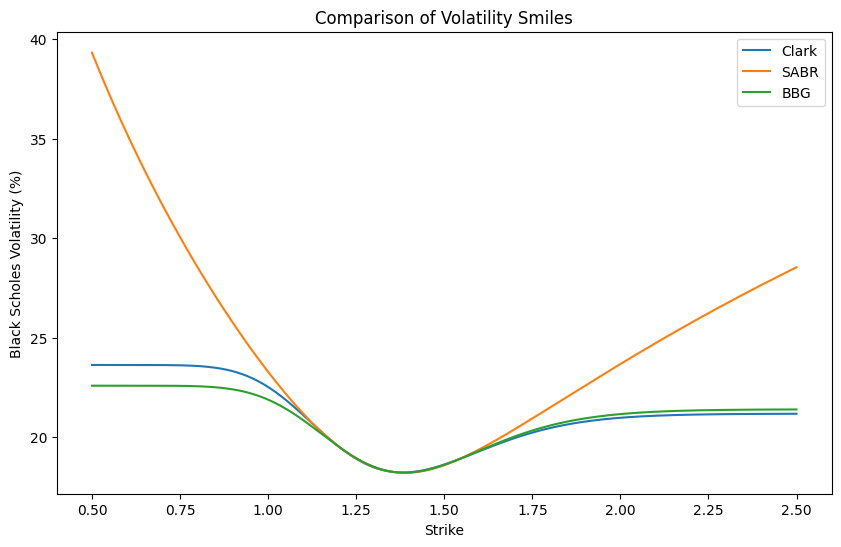

In [32]:
plt.figure(figsize=(10,6))
plt.plot(strikes, volsClark, label="Clark")
plt.plot(strikes, volsSABR, label="SABR")
plt.plot(strikes, volsBBG, label="BBG")
plt.xlabel("Strike")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Smiles")
plt.legend();

## Implied FX Rate Probability Density Functions

In [33]:
lower = 0.50
upper = 2.25
dbnClark = fxVolSurfaceClark.implied_dbns(lower, upper, 1000)
dbnSABR = fxVolSurfaceSABR.implied_dbns(lower, upper, 1000)
dbnBBG = fxVolSurfaceBBG.implied_dbns(lower, upper, 1000)

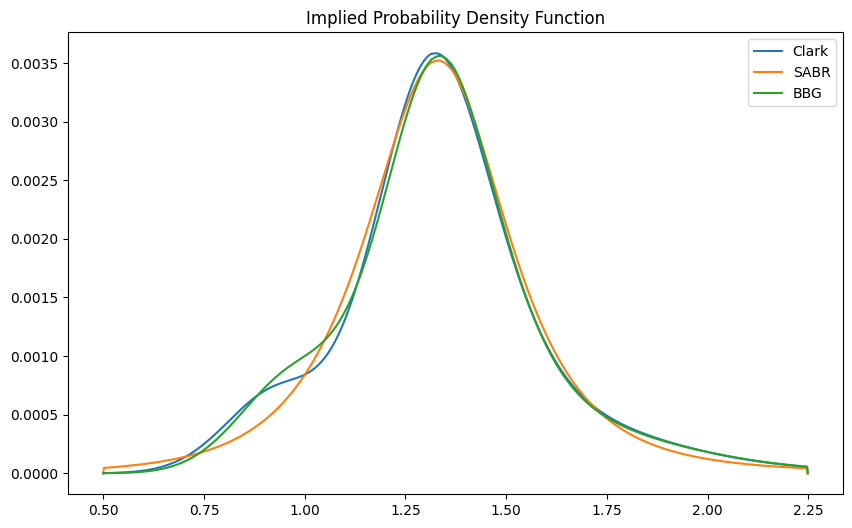

In [34]:
plt.figure(figsize=(10,6))
plt.plot(dbnClark[0]._x, dbnClark[0]._densitydx, label="Clark")
plt.plot(dbnSABR[0]._x, dbnSABR[0]._densitydx, label="SABR")
plt.plot(dbnBBG[0]._x, dbnBBG[0]._densitydx, label="BBG")
plt.title("Implied Probability Density Function")
plt.legend();

## Expiry Date Interpolation

We only have one expiry date. The volatility is therefore assumed to be flat at the level of this expiry date.

In [35]:
k = 1.30

In [36]:
years = np.linspace(0.0, 2.0, 100)

In [37]:
expiry_dts = value_dt.add_years(years)

In [38]:
volsClark = []
volsSABR = []
volsBBG = []

for expiry_dt in expiry_dts:

    volClark = fxVolSurfaceClark.volatility(k, expiry_dt)
    volSABR = fxVolSurfaceSABR.volatility(k, expiry_dt)
    volBBG = fxVolSurfaceBBG.volatility(k, expiry_dt)

    volsClark.append(volClark*100.0)
    volsSABR.append(volSABR*100.0)
    volsBBG.append(volBBG*100.0)

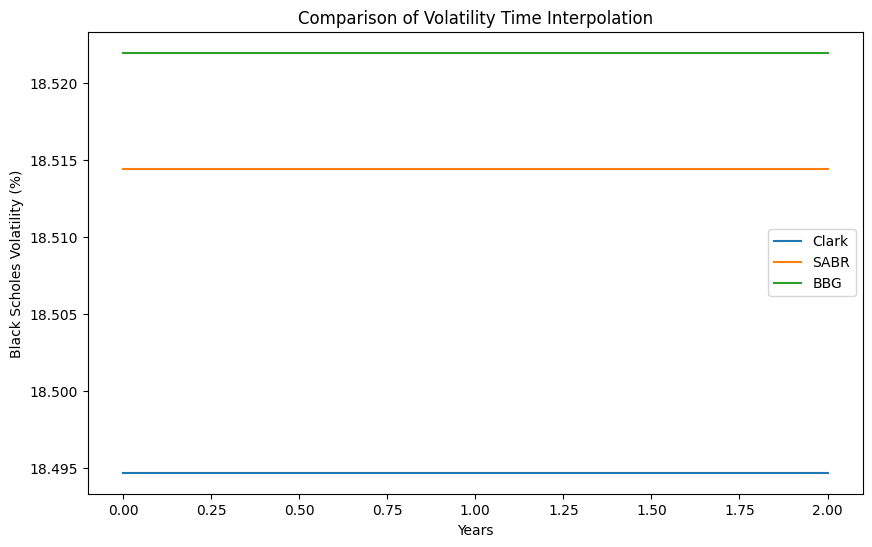

In [39]:
plt.figure(figsize=(10,6))
plt.plot(years, volsClark, label="Clark")
plt.plot(years, volsSABR, label="SABR")
plt.plot(years, volsBBG, label="BBG")
plt.xlabel("Years")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Time Interpolation")
plt.legend();

Copyright (c) 2020, Dominic O'Kane 